**Necessary Imports**

- Necessary libraries and modules are imported, including for data handling, plotting, and HTTP requests.

In [52]:
import os
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import re
from datetime import datetime, timezone
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
import plotly.graph_objects as go
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

headers = {
    'User-Agent': 'ChessDataFetcher/1.0 (ardilyuce@gmail.com)'
}

username = "ardil30"  # Chess.com username
raw_file_path = f"./data/raw/{username}_raw_games.json"
processed_json_path = f"./data/processed/{username}_games.json"
processed_csv_path = f"./data/processed/{username}_games.csv"
openings_file_path = "./data/processed/chess_openings.txt"

__Fetching Game Data from Chess.com API__

- This segment is responsible for fetching game data from Chess.com API for a given user. It retrieves the user's game archives, extracts all games from those archives, and saves the data as a formatted JSON file. The necessary directories are created, and the fetched data is stored in the specified path for further use.

In [53]:
def fetch_game_archives(username):
    """
    Fetch the game archives URLs for the player.
    """
    url = f'https://api.chess.com/pub/player/{username}/games/archives'
    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        print(f"Error fetching archives: HTTP {response.status_code}, {response.text}")
        return []
    archives = response.json().get('archives', [])
    print(f"Archives fetched: {len(archives)} archives found.")
    return archives

def fetch_games_from_archive(archive_url):
    """
    Fetch all games from a given archive URL.
    """
    response = requests.get(archive_url, headers=headers)
    if response.status_code != 200:
        print(f"Error fetching games from {archive_url}: HTTP {response.status_code}, {response.text}")
        return []
    games = response.json().get('games', [])
    return games

def fetch_all_games(username):
    """
    Fetch all games by iterating through their game archives.
    """
    all_games = []
    archives = fetch_game_archives(username)
    if not archives:
        print("No archives fetched. Ensure the username is correct or the Chess.com API is accessible.")
        return all_games

    for archive_url in archives:
        games = fetch_games_from_archive(archive_url)
        all_games.extend(games)

    return all_games

def save_to_json(data, filename):
    """
    Save data to a beautified JSON file.
    """
    print(f"Saving data to {filename}...")
    if not data:
        print("No data to save. The file will not be updated.")
        return

    with open(filename, "w") as file:
        json.dump(data, file, indent=4)
    print(f"Data saved successfully to {filename}. File size: {os.path.getsize(filename)} bytes")

# Main code

# Ensure the raw data directory exists
os.makedirs(os.path.dirname(raw_file_path), exist_ok=True)

# Fetch new games
all_games = fetch_all_games(username)

# Save fetched data
save_to_json(all_games, raw_file_path)

Archives fetched: 27 archives found.
Saving data to ./data/raw/ardil30_raw_games.json...
Data saved successfully to ./data/raw/ardil30_raw_games.json. File size: 7609450 bytes


__Processing and Saving Game Data with Openings__

- This part of the code is focused on processing game data retrieved from Chess.com, enriching it with the main opening and variation details. It ensures the main openings are stored in a file, processes each game's PGN data to extract the relevant information, determines the game result, and categorizes the opening. Finally, the processed data is saved in both JSON and CSV formats for further analysis or use.

In [54]:
def load_openings(file_path):
    """
    Load a list of main openings from a text file.
    """
    # Ensure the file exists
    if not os.path.exists(file_path):
        with open(file_path, "w") as file:
            pass  # Create an empty file

    with open(file_path, "r") as file:
        return [line.strip().lower() for line in file if line.strip()]

def add_opening_to_file(file_path, opening):
    """
    Add a new opening to the openings file if it doesn't already exist.
    """
    openings = load_openings(file_path)
    opening_lower = opening.lower()
    if opening_lower not in openings:
        with open(file_path, "a") as file:
            file.write(opening + "\n")
        print(f"New opening added to {file_path}: {opening}")

def split_pgn(pgn):
    """
    Split PGN into metadata (headers) and move list.
    Format the metadata as a dictionary for better readability.
    """
    if not pgn:
        return {"Information": {}, "Moves": "No Moves available"}

    try:
        parts = pgn.split("\n\n")  # Split PGN into headers and moves
        metadata_lines = parts[0].strip().split("\n")  # Split headers by lines
        moves = parts[1].strip() if len(parts) > 1 else "No Moves available"  # Moves section

        # Convert metadata lines to a dictionary
        metadata = {}
        for line in metadata_lines:
            if line.startswith("[") and line.endswith("]"):
                key_value = line[1:-1].split(" ", 1)  # Remove brackets and split by the first space
                if len(key_value) == 2:
                    key, value = key_value
                    metadata[key] = value.strip('"')  # Remove quotes around values

        return {"Information": metadata, "Moves": moves}
    except IndexError:
        return {"Information": {}, "Moves": "Invalid PGN format"}

def determine_game_result(game, username):
    """
    Determine the result of the game for the given player.
    """
    white_player = game.get("white", {}).get("username", "").lower()
    black_player = game.get("black", {}).get("username", "").lower()
    white_result = game.get("white", {}).get("result", "").lower()
    black_result = game.get("black", {}).get("result", "").lower()

    if username.lower() == white_player.strip().lower():
        if white_result == "win":
            return "Win"
        elif white_result in ["checkmated", "timeout", "resigned", "abandoned"]:
            return "Loss"
        elif white_result in ["stalemate", "draw", "insufficient material", "insufficient", "repetition", "agreed", "50move", "timevsinsufficient"]:
            return "Draw"
    elif username.lower() == black_player.strip().lower():
        if black_result == "win":
            return "Win"
        elif black_result in ["checkmated", "timeout", "resigned", "abandoned"]:
            return "Loss"
        elif black_result in ["stalemate", "draw", "insufficient material", "insufficient", "repetition", "agreed", "50move", "timevsinsufficient"]:
            return "Draw"
    return "Unknown"

def extract_opening_from_pgn(metadata):
    """
    Extract the opening name from the PGN metadata (based on Chess.com opening URL).
    Removes any single quotes from the opening name.
    """
    eco_url = metadata.get("ECOUrl", "")
    if eco_url and "chess.com/openings/" in eco_url:
        opening_name = eco_url.split("chess.com/openings/")[-1].replace("-", " ").capitalize()
        opening_name = opening_name.replace("'", "")  # Remove any single quotes
        return opening_name
    return "Unknown"

def process_game_data(all_games, username, openings_file):
    """
    Beautify and structure game data with main openings and variations.
    """
    def unix_to_readable(unix_time):
        return datetime.fromtimestamp(unix_time, timezone.utc).strftime('%Y-%m-%d %H:%M:%S')

    # Load main openings from the text file
    main_openings = load_openings(openings_file)

    game_list = []
    for game in all_games:
        pgn_split = split_pgn(game.get("pgn", ""))
        metadata = pgn_split.get("Information", {})

        # Extract opening name from the ECO URL
        opening_name = extract_opening_from_pgn(metadata)

        # Determine game result
        game_result = determine_game_result(game, username)

        # Initialize variables for Main Opening and Variation
        main_opening = "Unknown"
        variation = opening_name

        # Check if the extracted opening matches any of the known main openings
        for main in main_openings:
            if opening_name.lower().find(main.lower()) != -1:  # Compare opening with main openings
                main_opening = main  # Assign the main opening name if a match is found
                variation = opening_name.strip().capitalize()  # Set variation
                break

        # If the opening is unknown, add it to the file and update the game entry
        if main_opening == "Unknown" and opening_name != "Unknown":
            add_opening_to_file(openings_file, opening_name)  # Add the unknown opening to the file
            main_opening = opening_name  # Set the unknown opening as the main opening
            variation = "Unknown"  # Set the variation as "Unknown" when the opening is new

        # Construct the game entry with all relevant information
        game_entry = {
            "Game URL": game.get("url", ""),
            "Time Class": game.get("time_class", "N/A").capitalize(),
            "End Time": unix_to_readable(game.get("end_time", 0)),
            "White Player": game.get("white", {}).get("username", "Unknown"),
            "White Rating": game.get("white", {}).get("rating", "N/A"),
            "Black Player": game.get("black", {}).get("username", "Unknown"),
            "Black Rating": game.get("black", {}).get("rating", "N/A"),
            "Result": game_result,  # Processed result as "Win", "Loss", or "Draw"
            "Main Opening": main_opening,  # Main opening assigned from the file or extracted
            "Variation": variation,  # Variation assigned from the ECO URL or input
            "Information": pgn_split["Information"],  # PGN metadata
            "Moves": pgn_split["Moves"]  # Game moves
        }

        # Add the game entry to the list if the game has proper rules
        if game.get("rules", "") == "chess":
            game_list.append(game_entry)
    
    return game_list

def save_to_csv(data, filename):
    """
    Save data to a CSV file.
    """
    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)
    print(f"Data saved to {filename} (CSV format)")

def save_to_json(data, filename):
    """
    Save data to a beautified JSON file.
    """
    with open(filename, "w") as file:
        json.dump(data, file, indent=4)
    print(f"Data saved to {filename} (JSON format)")

# Main code

# Ensure the processed data directory exists
os.makedirs("./data/processed", exist_ok=True)

# Load raw data
with open(raw_file_path, "r") as file:
    raw_data = json.load(file)

# Process data
processed_data = process_game_data(raw_data, username, openings_file_path)

# Save processed data
save_to_json(processed_data, processed_json_path)
save_to_csv(processed_data, processed_csv_path)


Data saved to ./data/processed/ardil30_games.json (JSON format)
Data saved to ./data/processed/ardil30_games.csv (CSV format)


__Loading Processed Game Data__
- This part of the code loads the previously processed game data from a JSON file. The data is then stored in a DataFrame, making it ready for further analysis or visualization.

In [55]:
def load_processed_data(file_path):
    """
    Load the processed game data from a JSON file.
    """
    return pd.read_json(file_path)

data = load_processed_data(processed_json_path)

__Preparing and Plotting Smoothed Rating Trends__
- This code prepares data for trend analysis by extracting the relevant columns, calculating the player's rating, and applying a moving average to smooth the rating trends. It then uses Plotly to generate interactive line plots displaying the smoothed rating trends over time, with separate plots for different time controls (Blitz, Bullet, and Rapid). The moving average helps reduce noise in the data, providing a clearer trend visualization.

In [56]:
def prepare_trend_data(data, username, window_size=5):
    """
    Prepare data for trend analysis by extracting relevant columns and applying smoothing.
    """
    # Convert end time to datetime
    data['End Time'] = pd.to_datetime(data['End Time'])

    # Add player rating column
    data['Player Rating'] = data.apply(
        lambda row: row['White Rating'] if row['White Player'] == username else row['Black Rating'], axis=1
    )

    # Add opponent rating column
    data['Opponent Rating'] = data.apply(
        lambda row: row['Black Rating'] if row['White Player'] == username else row['White Rating'], axis=1
    )

    # Sort by time
    data = data.sort_values('End Time')

    # Apply moving average to smooth ratings
    data['Smoothed Rating'] = data.groupby('Time Class')['Player Rating'].transform(
        lambda x: x.rolling(window=window_size, min_periods=1).mean()
    )

    return data[['End Time', 'Time Class', 'Player Rating', 'Smoothed Rating', 'Opponent Rating']]

def plot_time_control(trend_data, time_class):
    """
    Plot smoothed rating trends for a specific time control using Plotly.
    """
    subset = trend_data[trend_data['Time Class'] == time_class]

    # Debugging: Check if subset has data
    if subset.empty:
        print(f"No data found for time class: {time_class}")
        return

    # Create a Plotly figure
    fig = go.Figure()

    # Add the smoothed rating as a line plot with markers
    fig.add_trace(
        go.Scatter(
            x=subset['End Time'],
            y=subset['Smoothed Rating'],
            mode='lines+markers',  # Lines and markers for individual points
            marker=dict(color='skyblue', size=5),
            hovertemplate='<br>'.join([
                'Rating: %{y}',
                'Date: %{x}'
            ]),
            name=f"{time_class.capitalize()} Rating"
        )
    )

    # Update layout with title and labels
    fig.update_layout(
        title_text=f"{time_class.capitalize()} Rating Trends Over Time (Smoothed)",
        xaxis=dict(
            title='Date',
            type='date',
            rangeslider=dict(visible=True),
            rangeselector=dict(
                buttons=list([
                    dict(count=1, label="1m", step="month", stepmode="backward"),
                    dict(count=6, label="6m", step="month", stepmode="backward"),
                    dict(count=1, label="1y", step="year", stepmode="backward"),
                    dict(step="all")
                ])
            ),
            showspikes=True,
            spikecolor="purple",
            spikesnap="cursor",
            spikemode="across"
        ),
        yaxis=dict(
            title='Rating',
            showspikes=True,
            spikecolor="orange",
            spikethickness=2
        ),
        plot_bgcolor='rgba(255, 255, 255, 0.8)',
        paper_bgcolor='rgba(255, 255, 255, 0.8)'
    )

    # Show the plot
    fig.show()

# Main code
# Assuming 'data' is already loaded with your dataset and 'username' is provided
# Prepare trend data with smoothing (less smoothing with window size 5)
trend_data = prepare_trend_data(data, username, window_size=5)

# Plot rating trends for each time control
plot_time_control(trend_data, "Blitz")
plot_time_control(trend_data, "Bullet")
plot_time_control(trend_data, "Rapid")


__Analyzing Main Openings and Win Rates__
- This code analyzes the most frequent main chess openings by counting the occurrences of each opening and their associated results (Win, Loss, or Draw). It filters out openings with fewer than 10 games, calculates the win rate for each opening, and sorts them by the total number of games. The top 10 most frequently played openings are displayed with their win rates rounded to 3 decimal places.

In [57]:
def analyze_openings(data):
    """
    Analyze most frequent main openings and their win rates.
    """
    # Filter out games with fewer than 10 games and calculate win rate directly
    opening_stats = data.groupby(['Main Opening', 'Result']).size().unstack(fill_value=0)

    # Add total games and filter for openings with 10 or more games
    opening_stats['Total'] = opening_stats.sum(axis=1)
    opening_stats = opening_stats[opening_stats['Total'] >= 10]

    # Calculate win rate for each opening
    opening_stats['Win Rate'] = opening_stats['Win'] / opening_stats['Total']

    # Sort by total games and select top 10, rounding the win rate
    return opening_stats.sort_values(by='Total', ascending=False).head(10).round({'Win Rate': 3})

# Analyze main openings
print("Analyzing main openings...")
top_10_openings = analyze_openings(data)

# Display the top 10 openings as a DataFrame
top_10_openings


Analyzing main openings...


Result,Draw,Loss,Win,Total,Win Rate
Main Opening,,,,,
pirc,17,164,174,355,0.490
english,17,138,197,352,0.560
reti,7,101,138,246,0.561
modern defense,11,76,93,180,0.517
caro kann,4,68,80,152,0.526
kings indian,3,32,47,82,0.573
sicilian,1,36,36,73,0.493
giuoco piano,2,29,37,68,0.544
indian game,4,22,40,66,0.606


__Grouping Games by Rating Differential and Plotting Win Rates__

- This code calculates the rating differential for each game based on the player's rating and their opponent's rating. It groups games into intervals (e.g., -70 to -60, -60 to -50) and calculates the win rate for each interval. The results are then plotted, displaying the win rate for each rating differential bin. The graph includes annotations with the number of games played in each bin.

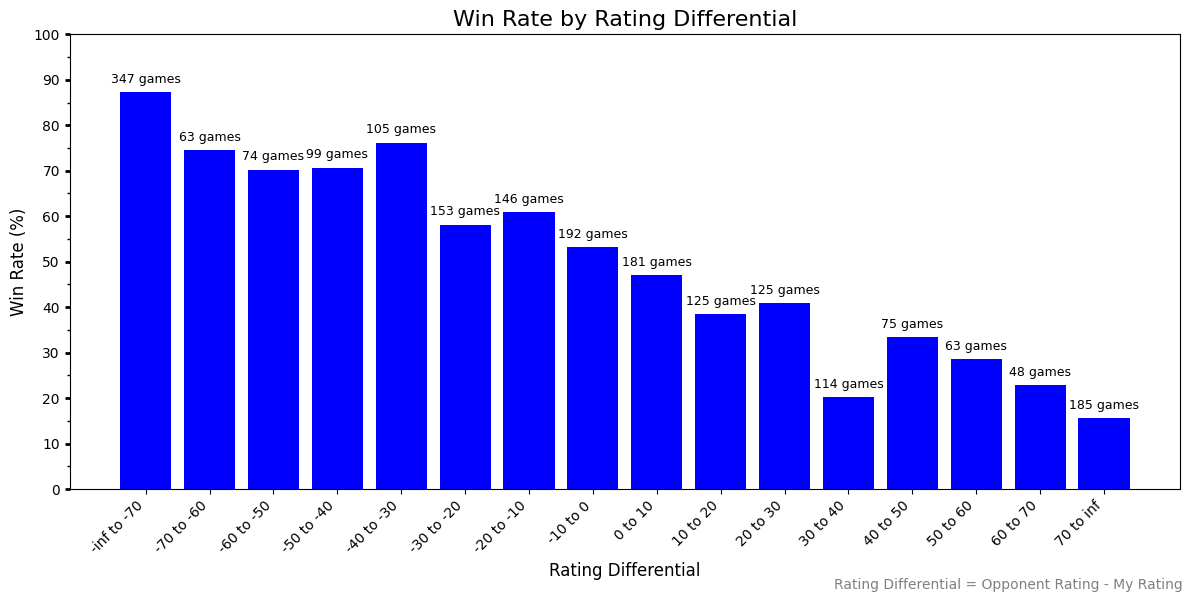

In [58]:
def calculate_rating_differential(row, username):
    """
    Calculate rating differential for the player (opponent_rating - my_rating).
    """
    player_rating = (
        row["White Rating"] if row["White Player"].lower() == username.lower()
        else row["Black Rating"]
    )
    opponent_rating = (
        row["Black Rating"] if row["White Player"].lower() == username.lower()
        else row["White Rating"]
    )
    return opponent_rating - player_rating

def group_by_rating_differential(data, username):
    """
    Group games by smaller rating differentials (10-point intervals) and calculate win rates.
    """
    # Calculate rating differential for each game
    data["Rating Differential"] = data.apply(
        lambda row: calculate_rating_differential(row, username), axis=1
    )

    # Define rating differential bins
    bins = [-float("inf")] + list(range(-70, 71, 10)) + [float("inf")]
    labels = [f"{bins[i]} to {bins[i+1]}" for i in range(len(bins) - 1)]

    # Categorize each game into a bin
    data["Rating Differential Bin"] = pd.cut(
        data["Rating Differential"], bins=bins, labels=labels, right=False
    )

    # Calculate win rate for each bin using `agg` instead of `apply`
    differential_stats = data.groupby("Rating Differential Bin", observed=True).agg(
        Games_Played=('Rating Differential', 'size'),
        Win_Rate=('Result', lambda x: (x == "Win").mean() * 100)
    ).reset_index()

    return differential_stats

def plot_stats(stats, title, xlabel, ylabel):
    """
    Plot win rates based on calculated stats.
    """
    plt.figure(figsize=(12, 6))
    bars = plt.bar(stats['Rating Differential Bin'], stats['Win_Rate'], color="blue")

    # Annotate each bar with the number of games played
    for bar, games in zip(bars, stats["Games_Played"]):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 2,
            f"{int(games)} games",
            ha="center",
            fontsize=9
        )

    # Add a note to the graph
    plt.figtext(
        0.99, 0.01, 
        "Rating Differential = Opponent Rating - My Rating", 
        horizontalalignment="right", fontsize=10, color="gray"
    )

    # Set chart limits and labels
    plt.ylim(0, 100)  # Y-axis from 0 to 100%
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.xticks(rotation=45, ha="right")
    
    # Customize y-axis ticks
    ax = plt.gca()  # Get the current axis
    ax.yaxis.set_major_locator(MultipleLocator(10))  
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))  
    
    # Customize tick lines (major and minor)
    ax.tick_params(axis="y", which="major", width=2)  # Thicker major ticks
    ax.tick_params(axis="y", which="minor", width=1)  # Thinner minor ticks
    
    plt.tight_layout()

    # Show the plot instead of saving it
    plt.show()

# Assuming `data` and `username` are already loaded
differential_stats = group_by_rating_differential(data, username)

plot_stats(
    differential_stats,
    "Win Rate by Rating Differential",
    "Rating Differential",
    "Win Rate (%)"
)


__Analyzing and Plotting Time Management by Game Outcome__

- This section of code analyzes the average time per move for each game outcome (Win, Draw, Loss) across different time formats (e.g., Blitz, Bullet, Rapid). It processes the player's move times, calculates the average time spent per move, and then visualizes the data in a bar chart. The chart distinguishes between Win, Draw, and Loss outcomes by using different colors and includes annotations on each bar with the corresponding time in seconds.

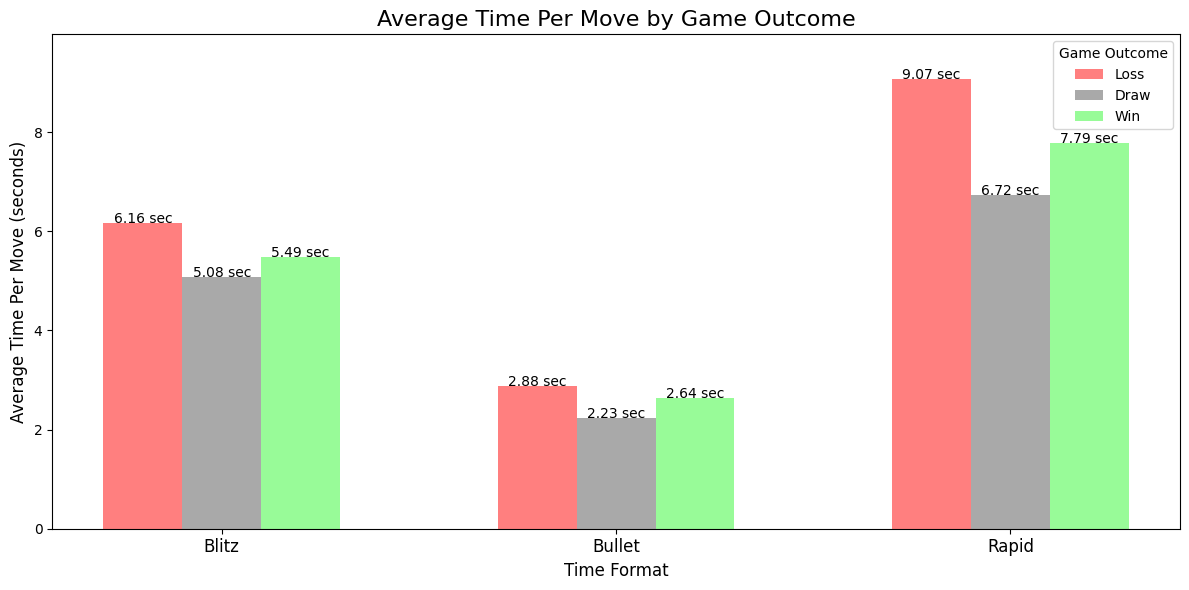

In [59]:
def to_seconds(time_str):
    """
    Convert a time string in the format hours:minutes:seconds to seconds.
    """
    parts = list(map(float, time_str.split(":")))
    if len(parts) == 2:  # Format: mm:ss
        return parts[0] * 60 + parts[1]
    elif len(parts) == 3:  # Format: hh:mm:ss
        return parts[0] * 3600 + parts[1] * 60 + parts[2]

def extract_time_per_move(moves, player_color):
    """
    Extract and calculate the average time per move for a player (White or Black).
    """
    if player_color.lower() not in ["white", "black"]:
        raise ValueError("player_color must be 'white' or 'black'.")

    # Extract times based on the player's moves
    if player_color.lower() == "white":
        times = re.findall(r"[^\.]\.\s[^\[]+\[%clk\s([0-9:.]+)\]", moves)
    elif player_color.lower() == "black":
        times = re.findall(r"\.\.\.\s[^\[]+\[%clk\s([0-9:.]+)\]", moves)

    if len(times) <= 1:  # Not enough data to calculate time per move
        return None

    # Convert times into seconds
    times_in_seconds = list(map(to_seconds, times))

    # Calculate time differences (time per move)
    time_diffs = [
        times_in_seconds[i] - times_in_seconds[i + 1]
        for i in range(len(times_in_seconds) - 1)
        if times_in_seconds[i] > times_in_seconds[i + 1]  # Ignore anomalies
    ]
    return sum(time_diffs) / len(time_diffs) if time_diffs else None

def analyze_time_management(data, username):
    """
    Analyze time management for each time format and game outcome, focusing on the player's moves.
    """
    time_data = []

    for _, row in data.iterrows():
        if row["Time Class"].lower() == "daily":
            continue  # Exclude Daily games

        # Determine player's color
        player_color = "white" if row["White Player"].lower() == username.lower() else "black"
        
        # Extract average time per move for the player
        avg_time_per_move = extract_time_per_move(row["Moves"], player_color)

        if avg_time_per_move is not None:
            time_data.append({
                "Time Class": row["Time Class"],
                "Result": row["Result"],
                "Average Time Per Move": avg_time_per_move
            })

    # Convert to DataFrame
    time_data = pd.DataFrame(time_data)

    # Group by Time Class and Result
    grouped_data = time_data.groupby(["Time Class", "Result"]).agg({
        "Average Time Per Move": "mean"
    }).reset_index()

    return grouped_data

def plot_time_management(data):
    """
    Plot time management for all time formats in a single graph.
    """
    time_classes = data["Time Class"].unique()
    result_order = ["Loss", "Draw", "Win"]  # Desired order for results

    # Color mapping for each result
    color_map = {
        "Loss": "#ff7f7f",  # Light red for loss
        "Draw": "#a9a9a9",  # Dark gray for draw
        "Win": "#98fb98"    # Light green for win
    }

    # Prepare data for plotting
    bar_width = 0.2
    x_positions = {time_class: i for i, time_class in enumerate(time_classes)}
    offset_map = {result: (idx - 1) * bar_width for idx, result in enumerate(result_order)}

    plt.figure(figsize=(12, 6))

    for result in result_order:
        subset = data[data["Result"] == result]
        x_values = [x_positions[time_class] + offset_map[result] for time_class in subset["Time Class"]]
        y_values = subset["Average Time Per Move"]
        bars = plt.bar(x_values, y_values, bar_width, label=result, color=color_map[result])

        # Annotate bars
        for bar in bars:
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height(),
                f"{bar.get_height():.2f} sec",
                ha="center",
                fontsize=10
            )

    plt.xticks([x_positions[time_class] for time_class in time_classes], time_classes, fontsize=12)
    plt.ylim(0, max(data["Average Time Per Move"]) * 1.1)  # Add some padding
    plt.title("Average Time Per Move by Game Outcome", fontsize=16)
    plt.xlabel("Time Format", fontsize=12)
    plt.ylabel("Average Time Per Move (seconds)", fontsize=12)
    plt.legend(title="Game Outcome", fontsize=10)
    plt.tight_layout()

    # Show the plot
    plt.show()

time_management_stats = analyze_time_management(data, username)
plot_time_management(time_management_stats)


__Analyzing Game Results by Day of the Week__

- In this section, the code processes game data to categorize the results (Win, Loss, or Draw) for each day of the week. It groups the data by day and result, then creates a stacked bar chart showing the number of games played for each result category per day. The chart is color-coded to distinguish between Wins, Draws, and Losses, and it includes labels and a legend for clarity. This allows for an easy visual comparison of game outcomes across different days of the week.

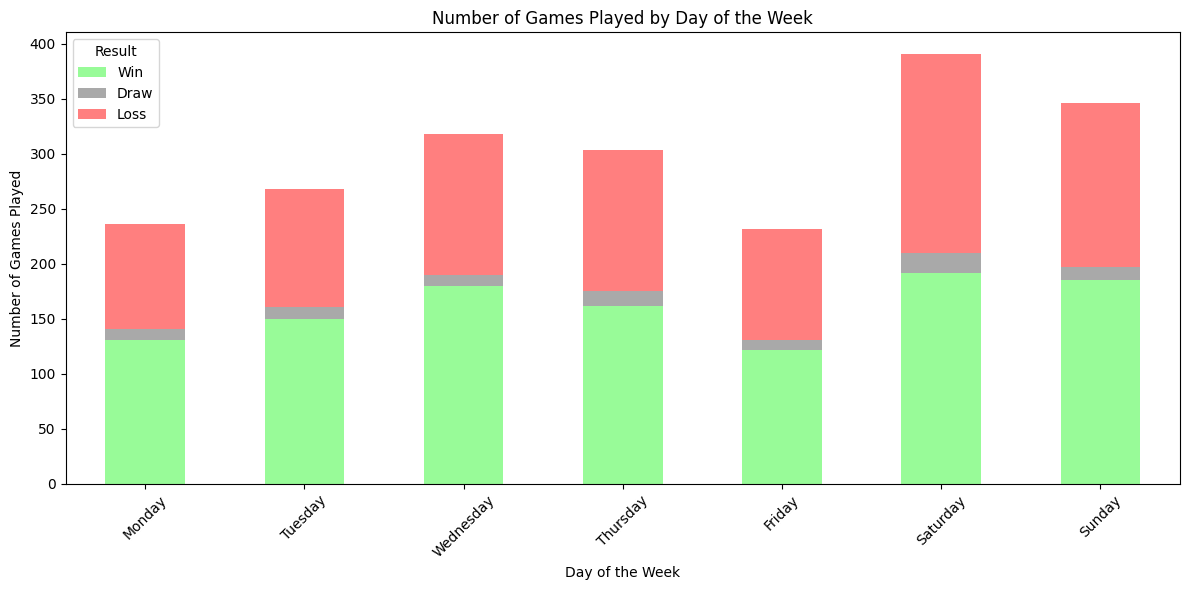

In [60]:
# Ensure the 'End Time' column is in datetime format
data['End Time'] = pd.to_datetime(data['End Time'])

# Extract the day of the week
data['day_of_week'] = data['End Time'].dt.day_name()

# Categorize results into win, loss, or draw
def map_result_to_category(result):
    if 'Win' in result:
        return 'Win'
    elif 'Loss' in result:
        return 'Loss'
    elif 'Draw' in result:
        return 'Draw'
    else:
        return 'Other'

data['Result Category'] = data['Result'].apply(map_result_to_category)

# Group data by day of the week and result category
result_by_day = data.groupby(['day_of_week', 'Result Category']).size().unstack(fill_value=0)

# Reorder the days of the week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
result_by_day = result_by_day.reindex(day_order)

# Define color shades
color_map = {
    'Win': '#98fb98',   # Pale green
    'Draw': '#a9a9a9',  # Dark gray
    'Loss': '#ff7f7f'   # Light red
}

# Plot the stacked bar chart
result_by_day[['Win', 'Draw', 'Loss']].plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6),
    color=[color_map['Win'], color_map['Draw'], color_map['Loss']]
)

# Add title and labels
plt.title('Number of Games Played by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Games Played')
plt.xticks(rotation=45)
plt.legend(title='Result')
plt.tight_layout()

# Show the plot instead of saving it
plt.show()


__Analyzing Number of Games Played by Month__

- This code extracts the year and month from the 'End Time' column and calculates the total number of games played in each month. It then generates a bar chart to visualize the number of games played over time, with each bar representing a month. The x-axis shows the year-month format, while the y-axis represents the count of games played in that month. The chart allows for an easy comparison of game activity month by month.

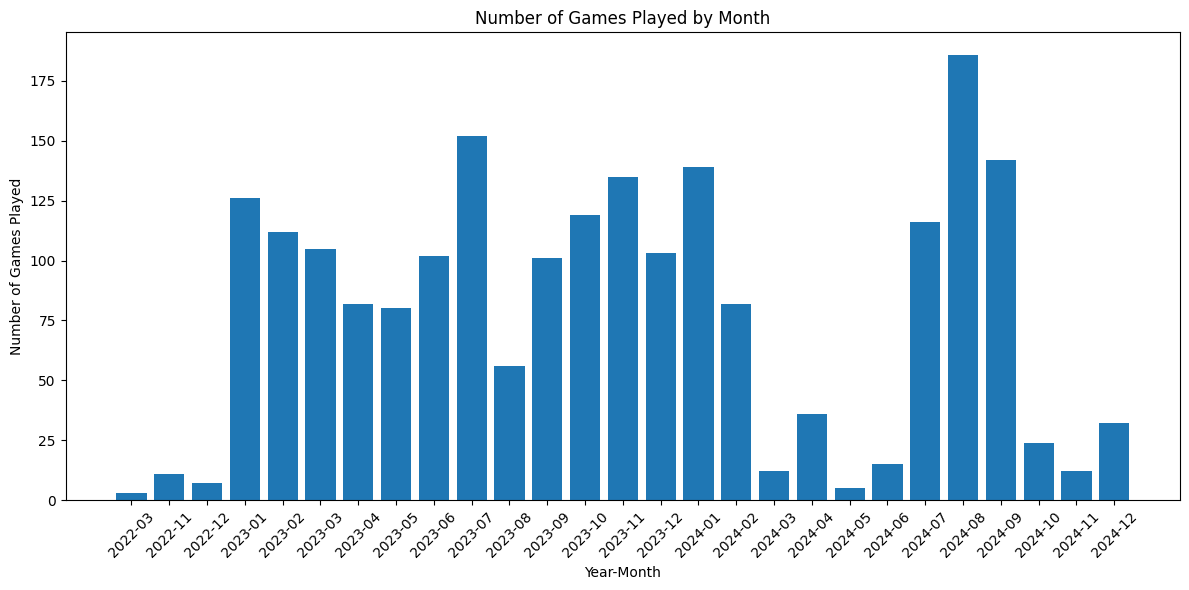

In [61]:
# Extract year and month
data['year_month'] = data['End Time'].dt.to_period('M')

# Count the number of games per year-month
games_by_month = data['year_month'].value_counts().sort_index()

# Convert to DataFrame for better handling
games_by_month_df = games_by_month.reset_index()
games_by_month_df.columns = ['Year-Month', 'Game Count']

# Plot the histogram
plt.figure(figsize=(12, 6))
plt.bar(games_by_month_df['Year-Month'].astype(str), games_by_month_df['Game Count'], width=0.8)
plt.xticks(rotation=45)
plt.xlabel('Year-Month')
plt.ylabel('Number of Games Played')
plt.title('Number of Games Played by Month')
plt.tight_layout()

# Show the plot instead of saving it
plt.show()


__Analyzing Games Played by Time of Day (Monthly)__

- This code categorizes the time of day for each game based on the 'End Time' and groups the games by month and time of day (Morning, Noon, Evening, Night). It then creates a stacked bar chart to show how many games were played during each time zone, for each month. The x-axis represents the months of the year, and the y-axis shows the number of games played during each time zone. The bars are color-coded to differentiate between the time zones.

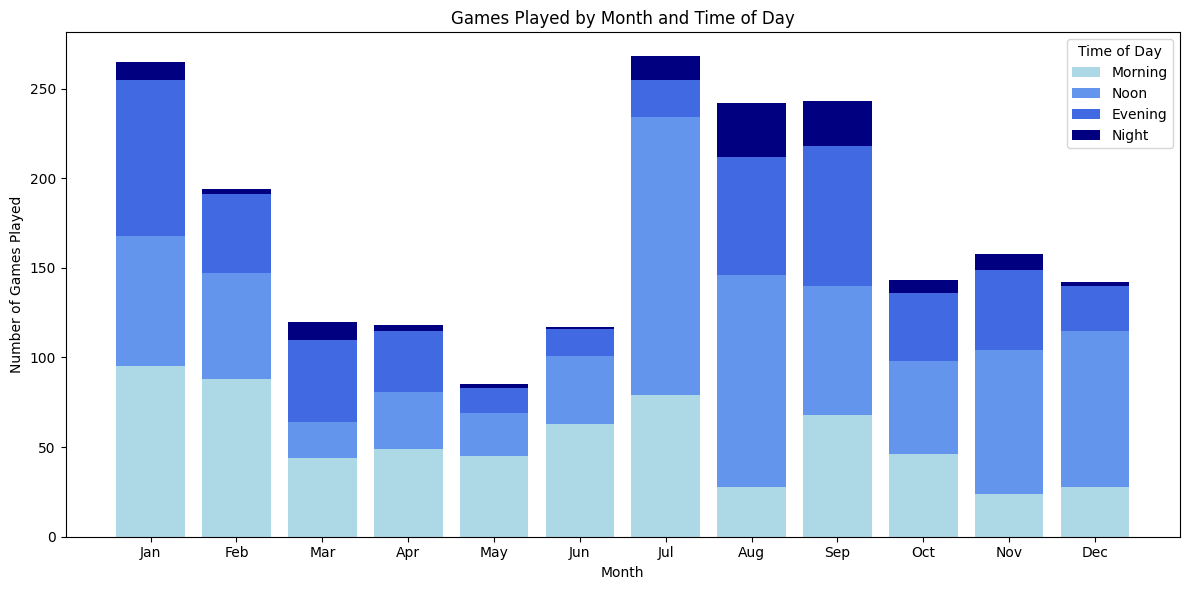

In [62]:
# Convert 'End Time' to datetime
data['End Time'] = pd.to_datetime(data['End Time'], errors='coerce')

# Initialize a nested dictionary for storing month-wise data and times of the day
month_time_of_day_count = {i: {'Morning': 0, 'Noon': 0, 'Evening': 0, 'Night': 0} for i in range(1, 13)}

def categorize_time(hour):
    """Categorizes the hour into Morning, Noon, Evening, or Night."""
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Noon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

# Iterate through the rows and update the nested dictionary with the count
for _, row in data.iterrows():
    if pd.notnull(row['End Time']):  # Ensure 'End Time' is valid
        month = row['End Time'].month  # Extract the month from 'End Time'
        hour = row['End Time'].hour   # Extract the hour from 'End Time'
        time_of_day = categorize_time(hour)  # Determine the time of day

        # Increment the count for the specific month and time of day
        month_time_of_day_count[month][time_of_day] += 1


# To plot the data, we will first extract the month and time categories and their counts.
months = list(month_time_of_day_count.keys())
time_of_day_categories = ['Morning', 'Noon', 'Evening', 'Night']

# Prepare the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Prepare the data for stacked bar chart
counts_morning = [month_time_of_day_count[month]['Morning'] for month in months]
counts_noon = [month_time_of_day_count[month]['Noon'] for month in months]
counts_evening = [month_time_of_day_count[month]['Evening'] for month in months]
counts_night = [month_time_of_day_count[month]['Night'] for month in months]

# Stack the bars by time of day
ax.bar(months, counts_morning, label='Morning', color='#add8e6')  # Light blue
ax.bar(months, counts_noon, bottom=counts_morning, label='Noon', color='#6495ed')  # Cornflower blue
ax.bar(months, counts_evening, bottom=[i+j for i,j in zip(counts_morning, counts_noon)], label='Evening', color='#4169e1')  # Royal blue
ax.bar(months, counts_night, bottom=[i+j+k for i,j,k in zip(counts_morning, counts_noon, counts_evening)], label='Night', color='#000080')  # Navy blue

# Customize the plot
ax.set_xlabel('Month')
ax.set_ylabel('Number of Games Played')
ax.set_title('Games Played by Month and Time of Day')
ax.set_xticks(months)  # Set x-ticks to months
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.legend(title='Time of Day')

# Display the plot
plt.tight_layout()
plt.show()


__Analyzing Longest Streaks of Wins, Losses, and Draws__

- This code calculates and tracks the longest consecutive streaks of wins, losses, and draws based on the "Result" column of the game data. The streaks are calculated by iterating through the results in chronological order, and the longest streak for each type (Win, Loss, Draw) is identified. It then outputs the longest streaks for each result type.

In [63]:
# Map results to streak types
data['streak_type'] = data['Result']

# Ensure streaks are sorted by game order (assuming games are in chronological order)
data = data.sort_values('End Time')

# Initialize variables to track the longest streaks
longest_streaks = {'Win': 0, 'Loss': 0, 'Draw': 0}
current_streak = {'type': None, 'count': 0}

# Iterate through the results and calculate streak lengths
for streak in data['streak_type']:
    if streak == current_streak['type']:
        current_streak['count'] += 1
    else:
        if current_streak['type']:
            longest_streaks[current_streak['type']] = max(longest_streaks[current_streak['type']], current_streak['count'])
        current_streak['type'] = streak
        current_streak['count'] = 1

# Handle the final streak
if current_streak['type']:
    longest_streaks[current_streak['type']] = max(longest_streaks[current_streak['type']], current_streak['count'])

# Display the longest streaks
print("Longest Streaks:")
for streak_type, streak_length in longest_streaks.items():
    print(f"{streak_type}: {streak_length} games")


Longest Streaks:
Win: 21 games
Loss: 10 games
Draw: 2 games


__Analyzing Win Rate Based on Time of Day__

- This code processes the game data by categorizing each game into a specific time of day (Morning, Noon, Evening, Night) based on the game's "End Time." It then calculates the win rate and match count for each time category. The results are sorted and displayed, with the win rate formatted as a percentage. This helps identify if the player's performance varies depending on the time of day.

In [64]:
# Extract the hour from 'End Time'
data['hour'] = data['End Time'].dt.hour

# Categorize hours into time zones
def categorize_time(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Noon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

data['time_of_day'] = data['hour'].apply(categorize_time)

# Determine if the game was a win
data['is_win'] = data['Result'].str.contains('Win', case=False)

# Group by time of day and calculate win rate and match count
stats_by_time_of_day = data.groupby('time_of_day').agg(
    matches_played=('is_win', 'size'),
    win_rate=('is_win', 'mean')
).reset_index()

# Define the custom sort order
time_of_day_order = ['Morning', 'Noon', 'Evening', 'Night']
stats_by_time_of_day['time_of_day'] = pd.Categorical(
    stats_by_time_of_day['time_of_day'], 
    categories=time_of_day_order, 
    ordered=True
)

# Sort the DataFrame
stats_by_time_of_day = stats_by_time_of_day.sort_values('time_of_day')

# Display the results directly in the notebook
stats_by_time_of_day['win_rate'] = stats_by_time_of_day['win_rate'].apply(lambda x: f"{x:.2%}")
stats_by_time_of_day

,time_of_day,matches_played,win_rate
1,Morning,657,49.92%
3,Noon,810,54.44%
0,Evening,513,57.50%
2,Night,115,50.43%


__Training a Model to Predict Game Outcomes__

- This code splits the chess game data (80-20) into training and testing sets, then trains a **Random Forest Classifier** to predict the outcome of a game (Win, Loss, or Draw) based on features like player ratings and opening choices. SMOTE is used to address class imbalance, ensuring better model performance. The model is evaluated using accuracy and confusion matrix, and the trained model is saved for future use.

Applying SMOTE with balanced sampling strategy...
Training Random Forest Classifier...
Evaluating model...
Accuracy: 0.6921241050119332


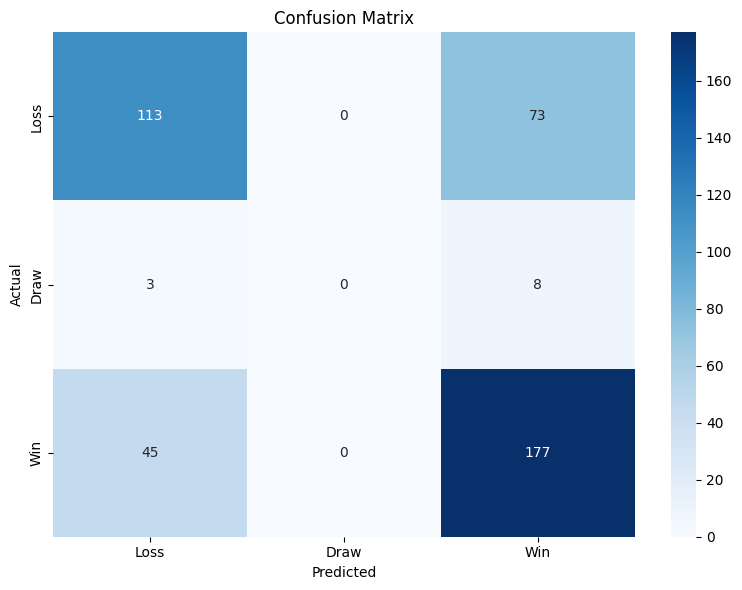

Saving model...
Model saved to ./ml/game_outcome_predictor_with_draws.pkl


In [65]:
def split_data(data, train_ratio=0.8):
    # Shuffle and split data into training and testing sets.
    data = data.sample(frac=1, random_state=42)  # Shuffle data
    train_size = int(len(data) * train_ratio)
    train_data = data[:train_size]
    test_data = data[train_size:]
    return train_data, test_data

def feature_engineering(data, username):
    # Add new features to enhance model performance.
    data["Rating Differential"] = data.apply(
        lambda row: row["Black Rating"] - row["White Rating"] if row["White Player"].lower() == username.lower() else row["White Rating"] - row["Black Rating"],
        axis=1
    )
    return data


def prepare_features_and_target(train_data, test_data, username):
    # Apply feature engineering
    train_data = feature_engineering(train_data, username)
    test_data = feature_engineering(test_data, username)

    # Define features and target
    features = ["White Rating", "Black Rating", "Rating Differential", "Time Class", "Main Opening"]
    X_train = train_data[features]
    y_train = train_data["Result"].map({"Win": 2, "Draw": 1, "Loss": 0})

    X_test = test_data[features]
    y_test = test_data["Result"].map({"Win": 2, "Draw": 1, "Loss": 0})

    # One-hot encode categorical features
    X_train = pd.get_dummies(X_train, columns=["Time Class", "Main Opening"])
    X_test = pd.get_dummies(X_test, columns=["Time Class", "Main Opening"])

    # Align test set to match training set columns
    X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

    return X_train, X_test, y_train, y_test

def train_model(X_train, y_train, use_smote=False):
    # Train a Random Forest Classifier, optionally using balanced SMOTE for oversampling.
    if use_smote:
        print("Applying SMOTE with balanced sampling strategy...")
        smote = SMOTE(
            sampling_strategy={0: len(y_train[y_train == 0]), 
                               1: len(y_train[y_train == 1]), 
                               2: len(y_train[y_train == 2])}, 
            random_state=42
        )
        X_train, y_train = smote.fit_resample(X_train, y_train)

    print("Training Random Forest Classifier...")
    model = RandomForestClassifier(
        class_weight={0: 1, 1: 1, 2: 1},  
        n_estimators=300,
        max_depth=10,
        min_samples_split=5,
        random_state=42
    )
    model.fit(X_train, y_train)
    return model

def evaluate_model(model, X_test, y_test):
    # Evaluate the model and print accuracy score.
    y_pred = model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Loss", "Draw", "Win"], yticklabels=["Loss", "Draw", "Win"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()

    # Show the confusion matrix plot instead of saving it
    plt.show()

def save_model(model, model_path):
    # Save the trained model to a file.
    os.makedirs(os.path.dirname(model_path), exist_ok=True)
    joblib.dump(model, model_path)
    print(f"Model saved to {model_path}")

# Main code
model_path = "./ml/game_outcome_predictor_with_draws.pkl"

train_data, test_data = split_data(data, train_ratio=0.8)

X_train, X_test, y_train, y_test = prepare_features_and_target(train_data, test_data, username)

model = train_model(X_train, y_train, use_smote=True)

# Evaluate model
print("Evaluating model...")
evaluate_model(model, X_test, y_test)

# Save model
print("Saving model...")
save_model(model, model_path)


__Training a Model to Predict Win/Loss Outcomes (Excluding Draws)__

- In this code, I train a **Random Forest Classifier** to predict the outcome of a chess game (Win or Loss) based on features such as player ratings, rating differential, and game opening. SMOTE is applied to address any class imbalance in the data. The model is trained using the processed data, evaluated on a test set, and the results (accuracy and confusion matrix) are displayed. Finally, the trained model is saved for future use. **Draws** are excluded from the dataset during both training and prediction since draws are really rare in my dataset.

Applying SMOTE with balanced sampling strategy...
Training Random Forest Classifier...
Evaluating model...
Accuracy: 0.7156862745098039


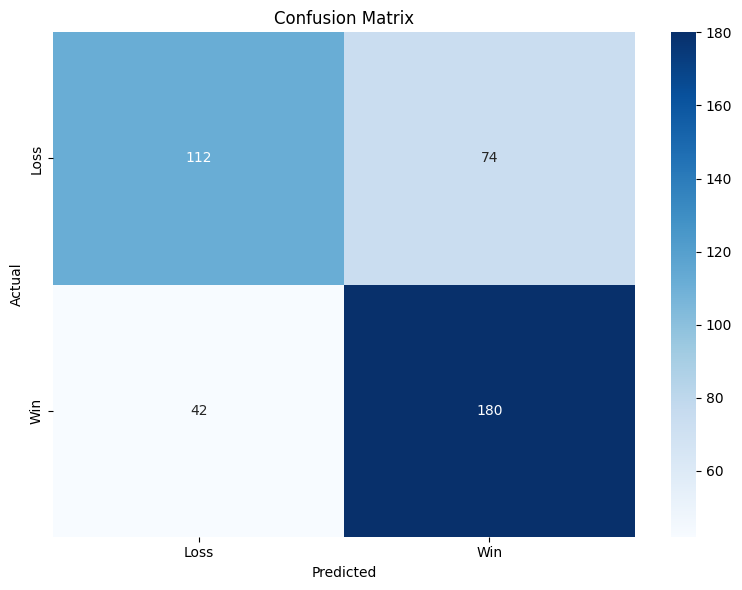

Saving model...
Model saved to ./ml/game_outcome_predictor_with_draws.pkl


In [66]:
def split_data(data, train_ratio=0.8):
    # Shuffle and split data into training and testing sets.
    data = data.sample(frac=1, random_state=42)  # Shuffle data
    train_size = int(len(data) * train_ratio)
    train_data = data[:train_size]
    test_data = data[train_size:]
    return train_data, test_data

def feature_engineering(data, username):
    # Add new features to enhance model performance.
    data["Rating Differential"] = data.apply(
        lambda row: row["Black Rating"] - row["White Rating"] if row["White Player"].lower() == username.lower() else row["White Rating"] - row["Black Rating"],
        axis=1
    )
    return data

def prepare_features_and_target(train_data, test_data, username):
    # Filter out draws to focus on Win/Loss results only, using .loc to avoid SettingWithCopyWarning
    train_data = train_data.loc[train_data["Result"] != "Draw"].copy()  # Use .loc and .copy()
    test_data = test_data.loc[test_data["Result"] != "Draw"].copy()  # Use .loc and .copy()

    # Apply feature engineering
    train_data = feature_engineering(train_data, username)  # Pass username
    test_data = feature_engineering(test_data, username)    # Pass username

    # Define features and target
    features = ["White Rating", "Black Rating", "Rating Differential", "Time Class", "Main Opening"]
    X_train = train_data[features]
    y_train = train_data["Result"].map({"Win": 2, "Loss": 0})  # Map "Win" to 2, "Loss" to 0

    X_test = test_data[features]
    y_test = test_data["Result"].map({"Win": 2, "Loss": 0})  # Map "Win" to 2, "Loss" to 0

    # One-hot encode categorical features
    X_train = pd.get_dummies(X_train, columns=["Time Class", "Main Opening"])
    X_test = pd.get_dummies(X_test, columns=["Time Class", "Main Opening"])

    # Align test set to match training set columns
    X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

    return X_train, X_test, y_train, y_test


def train_model(X_train, y_train, use_smote=False):
    # Train a Random Forest Classifier, optionally using balanced SMOTE for oversampling.
    if use_smote:
        print("Applying SMOTE with balanced sampling strategy...")
        smote = SMOTE(
            sampling_strategy={0: len(y_train[y_train == 0]), 
                               2: len(y_train[y_train == 2])}, 
            random_state=42
        )
        X_train, y_train = smote.fit_resample(X_train, y_train)

    print("Training Random Forest Classifier...")
    model = RandomForestClassifier(
        class_weight={0: 1, 2: 1},  # Only consider "Loss" and "Win" for class weight
        n_estimators=300,
        max_depth=10,
        min_samples_split=5,
        random_state=42
    )
    model.fit(X_train, y_train)
    return model

def evaluate_model(model, X_test, y_test):
    # Evaluate the model and print accuracy score.
    y_pred = model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Loss", "Win"], yticklabels=["Loss", "Win"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()

    # Show the confusion matrix plot instead of saving it
    plt.show()

def save_model(model, model_path):
    # Save the trained model to a file.
    os.makedirs(os.path.dirname(model_path), exist_ok=True)
    joblib.dump(model, model_path)
    print(f"Model saved to {model_path}")

# Main code
model_path = "./ml/game_outcome_predictor_with_draws.pkl"

train_data, test_data = split_data(data, train_ratio=0.8)

X_train, X_test, y_train, y_test = prepare_features_and_target(train_data, test_data, username)

model = train_model(X_train, y_train, use_smote=True)

# Evaluate model
print("Evaluating model...")
evaluate_model(model, X_test, y_test)

# Save model
print("Saving model...")
save_model(model, model_path)


__Null Hypothesis (H₀):__ The rating differential between the two players does not significantly affect the outcome of the game. This means that the rating differential does not influence whether the result will be a win or a loss.

__Alternative Hypothesis (H₁):__ The rating differential between the two players significantly affects the outcome of the game. This means that the rating differential influences the likelihood of a win or a loss.

Z-Test p-value: 0.0
We reject the null hypothesis: Rating differential between two people significantly affects the outcome of the game.


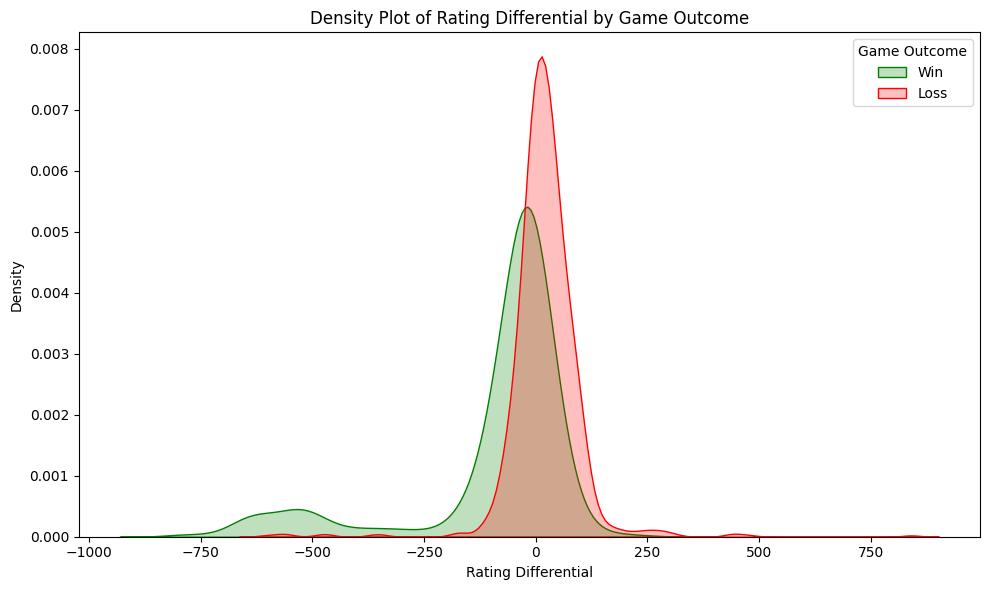

In [67]:
# Step 1: Prepare the Data

# Calculate Rating Differential
data["Rating Differential"] = data.apply(
    lambda row: row["Black Rating"] - row["White Rating"] if row["White Player"].lower() == username.lower() else row["White Rating"] - row["Black Rating"],
    axis=1
)

# Encode the Result as: Win = 1, Loss = 0
data['Result_encoded'] = data['Result'].map({'Win': 1, 'Loss': 0})

# Step 2: Separate Rating Differential by Game Outcome (Win, Loss)
win_data = data[data['Result_encoded'] == 1]['Rating Differential']
loss_data = data[data['Result_encoded'] == 0]['Rating Differential']

# Step 3: Calculate the Z-test for independent samples

# Calculate means and standard deviations
mean_win = win_data.mean()
mean_loss = loss_data.mean()

std_win = win_data.std()
std_loss = loss_data.std()

n_win = len(win_data)
n_loss = len(loss_data)

# Z-Test formula
z_value = (mean_win - mean_loss) / np.sqrt((std_win**2 / n_win) + (std_loss**2 / n_loss))

# Two-tailed p-value
p_value_rating = 2 * (1 - stats.norm.cdf(abs(z_value)))

# Step 4: Hypothesis Testing Decision
print(f"Z-Test p-value: {p_value_rating}")
if p_value_rating <= 0.05:
    print("We reject the null hypothesis: Rating differential between two people significantly affects the outcome of the game.")
else:
    print("We fail to reject the null hypothesis: Rating differential between two people does not significantly affect the outcome of the game.")

# Step 5: Visualization of Rating Differential by Game Outcome
# Kernel Density Estimate (KDE) Plot
plt.figure(figsize=(10, 6))
sns.kdeplot(win_data, color="green", label="Win", fill=True)
sns.kdeplot(loss_data, color="red", label="Loss", fill=True)
plt.title('Density Plot of Rating Differential by Game Outcome')
plt.xlabel('Rating Differential')
plt.ylabel('Density')
plt.legend(title="Game Outcome")
plt.tight_layout()
plt.show()
